In [1]:
%cd /mnt/home/zzhang/ceph/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import numpy as np
import tensorflow as tf
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

/mnt/home/zzhang/anaconda3/envs/crispr/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
x = np.load('./data/compiled_X.npy')
y = np.load('./data/compiled_Y.npy')

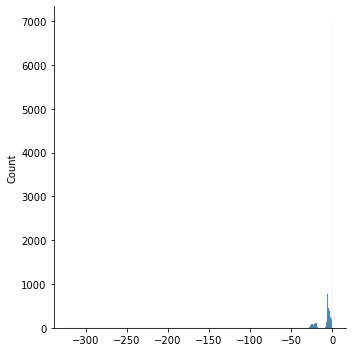

In [4]:
sns.displot(y[:,1])

In [5]:
for i in range(y.shape[1]):
    y[:,i] = ss.mstats.winsorize(y[:,i], limits=[0.025, 0.025])

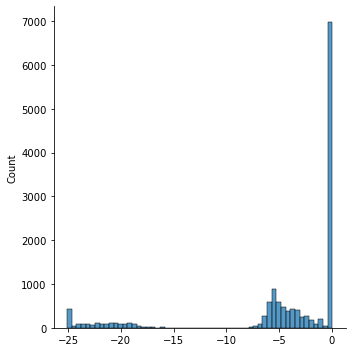

In [6]:
sns.displot(y[:,1])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(input_shape=(25,13), kernel_size=1, filters=10, activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation="linear")
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25, 10)            140       
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 251       
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss="mse", optimizer="sgd")

In [11]:
model.fit(x_train,
          y_train[:,1],
          batch_size=32,
          validation_split=0.2, epochs=200,
          verbose=0)

In [12]:
y_hat = model.predict(x_test).flatten()

/mnt/home/zzhang/anaconda3/envs/crispr/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


spearman SpearmanrResult(correlation=0.8778197928444642, pvalue=0.0)
pearson (0.7613831515013036, 0.0)


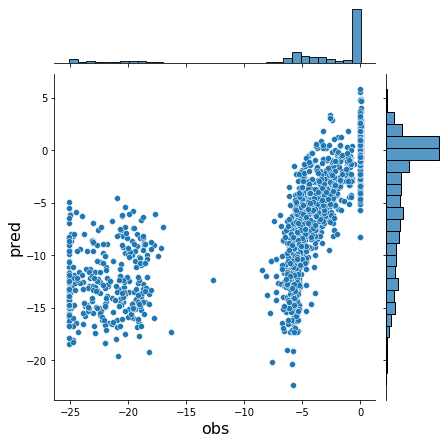

In [13]:
h = sns.jointplot(y_test[:,1], y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test[:,1]))
print("pearson", ss.pearsonr(y_hat, y_test[:,1]))